# ch 10_11 one-way ANOVA

t-test를 이용하여 두 집단의 평균이 같은지 다른지를 검정할 수 있었습니다. 그런데 집단이 3개 이상일 경우에는 어떻게 하면 좋을까요? 예를들어 A 대학, B대학, C 대학의 남학생들의 키가 같은지 다른지를 검정하고 싶다면 어떻게 할 수 있을까요? 가장 먼저 떠오르는 방법은 각각의 쌍에 대해서 여러번 t-test를 돌리는 방법입니다.

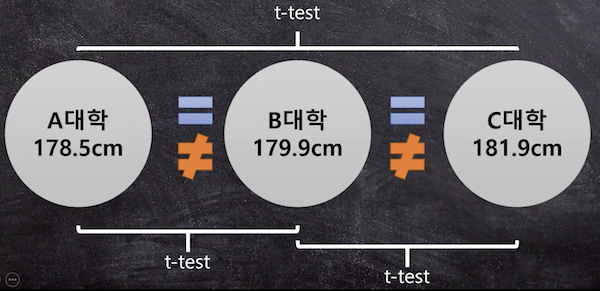

이런 식으로 t-test를 여러번 돌리는 것을 multiple t-test라고 부릅니다. 하지만 이 방법을 그대로 적용하면 안됩니다. A 대학 남학생의 평균 키와 B 대학의 남학생의 평균 키가 같다는 귀무 가설을 세우고, 유의 수준 0.05로 검정을 합니다. 같은 방식으로 A와 C 대학, B와 C 대학 간에 t-test를 진행합니다. 그리고 각각의 유의 수준은 0.05 입니다.

세번의 t-test를 함으로써 허용하게 되는 전체의 유의 수준은 0.05 + 0.05 + 0.05인 0.15가 됩니다.(정확하게 0.15는 아닙니다만, 이에 근사합니다.) 유의 수준은 허용 가능한 1종 오류이므로, t-test를 중복하여 수행하여 세 집단의 평균이 같은지 여부를 검정하면 심각한 1종 오류를 범하게 됩니다.

이런 상황에서 사용할 수 있는 기법이 ANOVA입니다. ANOVA도 종류가 많지만 가장 기본적인 one-way ANOVA를 배워보겠습니다.

## ANOVA

ANOVA는 analysis of variance의 약자로 한국어로 분산 분석입니다. 그런데 이는 3개 이상의 집단의 평균이 같은지, 다른지를 검정할 때 사용한다고 했습니다. 그렇다면 왜 이름이 분산 분석일까요? 바로 가설 검정에 사용하는 통계량을 2개의 분산 값의 비율로 계산하기 때문입니다. 지금부터 ANOVA에서 사용하는 2개의 분산 값은 무엇인지, 이를 통해 어떻게 세 집단의 평균이 같은지 다른지 검정하는지 살펴보겠습니다.

## 귀무 가설과 대립 가설 설정

우리가 알고 싶은 것은 3개 이상의 집단의 평균이 같은지, 다른지 여부입니다. 귀무 가설과 대립 가설을 세워보면 아래와 같습니다.

귀무 가설: 모든 그룹의 평균이 같다.  
대립 가설: 적어도 한 그룹의 평균은 다르다.

$$H_{0}: \mu_{1}=\mu_{2}=...=\mu_{k}$$
$$H_{a}: \mu_{i}\neq\mu_{j}\;for\;some\;i,j$$

## 예제 데이터

가설을 세웠으니 이제 검정 통계량을 설정해야합니다. ANOVA에서는 2개의 분산의 비율을 검정 통계량으로 사용합니다. 바로 전체 평균과 그룹 별 평균의 차의 분산인 between variance와 그룹 내 분산인 within variance입니다. 예제를 통해서 자세히 알아보겠습니다.

*Q. 어느 인터넷 ISP 기업이 고객의 총 지불 금액(TotalCharges)이 고객들의 지불 방법(Payment Method)에 따라 차이가 있는지 알고 싶어한다.*

In [3]:
import pandas as pd

df = pd.read_csv("./data/telco_customer_churn.csv")
df = df[["TotalCharges", "PaymentMethod"]]

In [4]:
df

,TotalCharges,PaymentMethod
0,29.85,Electronic check
1,1889.50,Mailed check
2,108.15,Mailed check
3,1840.75,Bank transfer
4,151.65,Electronic check
...,...,...
7038,1990.50,Mailed check
7039,7362.90,Credit card
7040,346.45,Electronic check
7041,306.60,Mailed check


### 결측치 제거

In [5]:
df.isnull().sum()

TotalCharges     11
PaymentMethod     0
dtype: int64

In [6]:
df = df.dropna()

In [7]:
import seaborn as sns
from matplotlib import pyplot as plt

<Axes: xlabel='PaymentMethod', ylabel='TotalCharges'>

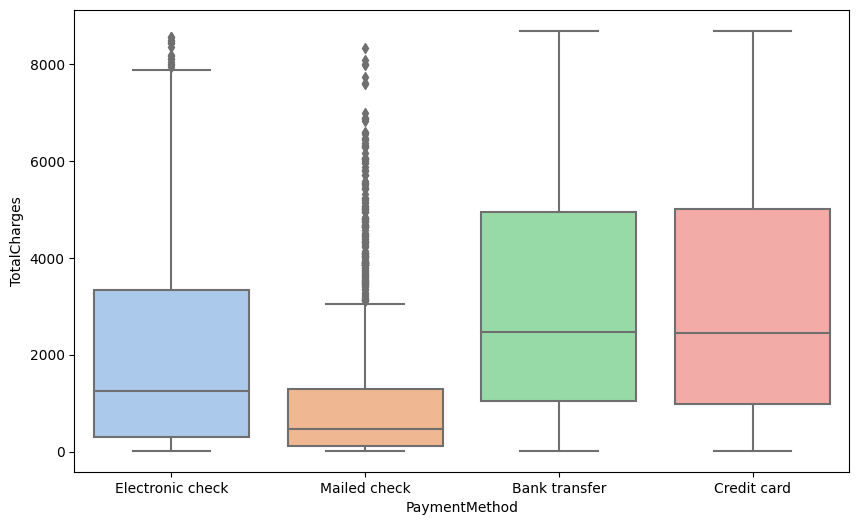

In [8]:
plt.figure(figsize=(10, 6))
sns.boxplot(
    x="PaymentMethod",
    y="TotalCharges",
    palette="pastel",
    data=df,
)

/var/folders/wx/2vw1xwz972zdxff5h8gzrml00000gn/T/ipykernel_88996/796037114.py:2: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(


<Axes: xlabel='PaymentMethod', ylabel='TotalCharges'>

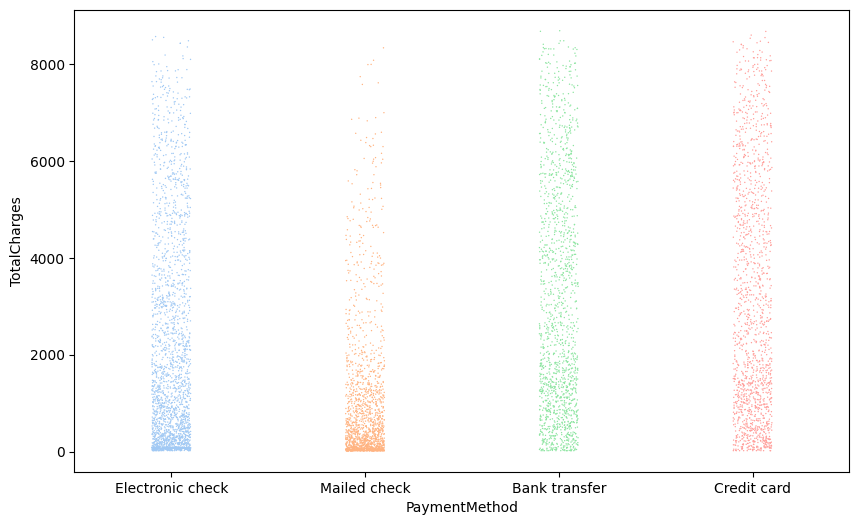

In [9]:
plt.figure(figsize=(10, 6))
sns.stripplot(
    x="PaymentMethod",
    y="TotalCharges",
    palette="pastel",
    data=df,
    size=1
)

Electronic check, Mailed check, Bank transfer, Credit card 네 가지 지불 수단이 있습니다. Bank transfer와 Credit card의 평균은 비슷해 보이고, 나머지 집단과의 평균은 달라보입니다만, 통계적으로 유의한 지는 아직 알 수 없습니다.

## 검정 통계량 f-value 계산 
ANOVA에서는 between variance와 within variance의 비율을 검정 통계량으로 사용한다고 했습니다. Between Variance는 전체 평균과 각 그룹별 평균의 차의 분산입니다. Within Variance는 각 그룹별 분산을 합하여 계산합니다.

Within Variace는 쉽게 이해가 가지만, between variance는 생소한 개념으로 plot을 그려서 이해해보겠습니다. 아래에서 빨간색 선으로 표시된 것은 모든 TotalCharges의 평균인 global mean입니다. 검은색 화살표로 표시된 값은 각 그룹별 평균과 전체 평균 사이의 차를 나타내며, 이 값들의 분산이 between variance가 됩니다.

/var/folders/wx/2vw1xwz972zdxff5h8gzrml00000gn/T/ipykernel_31852/1496878420.py:5: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(


Text(0.5, 1.0, 'mean per group and global mean')

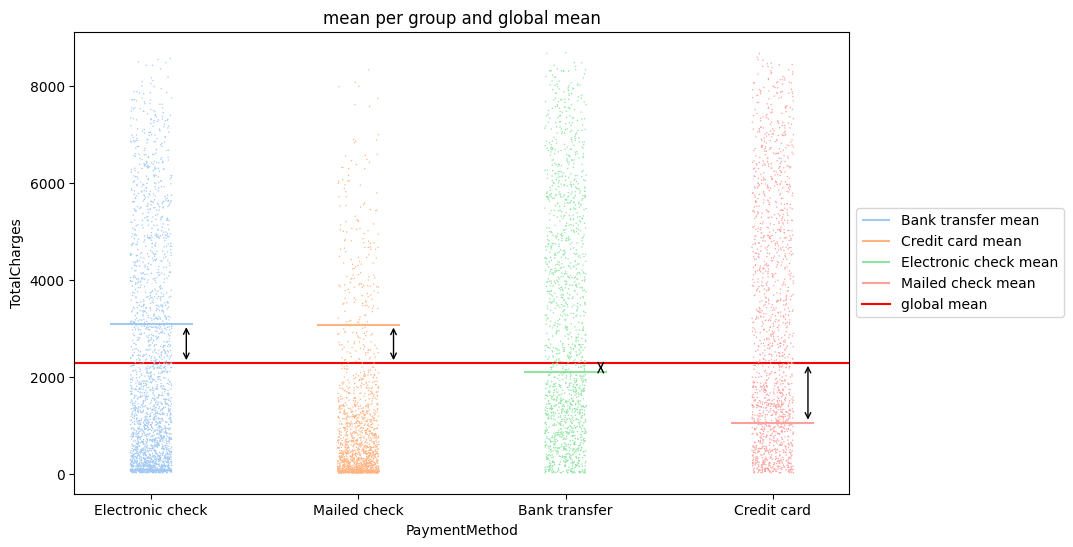

In [18]:
global_mean = df["TotalCharges"].mean()
means = df.groupby("PaymentMethod")["TotalCharges"].mean()

plt.figure(figsize=(10, 6))
sns.stripplot(
    x="PaymentMethod",
    y="TotalCharges",
    palette="pastel",
    data=df,
    size=1
)

line_width=0.2
line_height=200
pastel_palette = sns.color_palette('pastel', n_colors=len(df['PaymentMethod']))
arrow_props = dict(arrowstyle='<->', linewidth=1)

for i, (mean, index) in enumerate(zip(means, means.index)):
    plt.hlines(mean, xmin=(i-line_width), xmax=(i+line_width), label=f"{index} mean", color=pastel_palette[i])
    if global_mean >= mean:
        plt.annotate('', xy=(i+0.17, mean), xytext=(i+0.17, global_mean), arrowprops=arrow_props)
    else:
        plt.annotate('', xy=(i+0.17, global_mean), xytext=(i+0.17, mean), arrowprops=arrow_props)
        
plt.axhline(global_mean, color="r", label="global mean")

plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.title("mean per group and global mean")

between variance가 크다는 의미는 전체 평균으로부터 각 그룹의 평균값이 멀리 떨어져 있다는 의미입니다. 이는 곧 적어도 어떤 그룹 한개는 다른 그룹과 평균이 다를 수 있다는 근거가 됩니다. 그렇다면 이 between variance가 우연히 큰 건지, 아니면 유의미하게 큰 건지 판단할 기준이 필요합니다. 

Between Variance의 유의성을 검정하기 위해 구하는 것이 within variance, 즉 그룹 내 분산입니다. 이는 모든 그룹의 분산을 모두 계산한 다음 합쳐서 구합니다. 만약 Between Variance가 Within Variance 보다 유의하게 크다면, 그룹 간 평균이 다르다고 통계적으로 검정할 수 있습니다.

## f-value

이제 Between Variance와 Within Variance의 비로 f 값을 구할 수 있습니다. 그리고 t 값이 t 분포를 따르고, 카이 제곱 통계량이 카이 제곱 분포를 따랐던 것 처럼, f 값 역시 f 분포를 따릅니다.

$$k:\;그룹의\;개수,\;n:\;관찰값의\;개수$$

$$F-value=\frac{Between\;Variance}{Within\;Variance}\sim F(k-1, n-k)$$

Between Variance가 Within Variance보다 충분히 크다면, 즉 F-value가 충분히 크다면 적어도 어느 한 그룹의 평균값은 전체 평균과 다르다는 것을 알 수 있게 됩니다. 이것이 ANOVA의 핵심 개념입니다.

f-value를 계산하는 세부 수식이 궁금하신 분들은 아래 링크를 참고해주세요.
https://angeloyeo.github.io/2020/02/29/ANOVA.html

## f 분포
두 확률변수 V1, V2가 자유도 k1, k2이고 서로 독립인 카이제곱 분포를 따른다고 할 때, 다음과 같이 정의되는 확률 변수 F는 자유도가 (k1, k2)인 f-분포를 따른다고 합니다.

$$F=\frac{V_{1}/k_{1}}{V_{2}/k_{2}} \sim F(k_{1}, k_{2})$$

확률 밀도 함수는 아래 처러 생겼습니다.
$${\displaystyle g(x)={\frac {1}{\mathrm {B} (d_{1}/2,d_{2}/2)}}\;\left({\frac {d_{1}\,x}{d_{1}\,x+d_{2}}}\right)^{d_{1}/2}\;\left(1-{\frac {d_{1}\,x}{d_{1}\,x+d_{2}}}\right)^{d_{2}/2}\;x^{-1}}$$

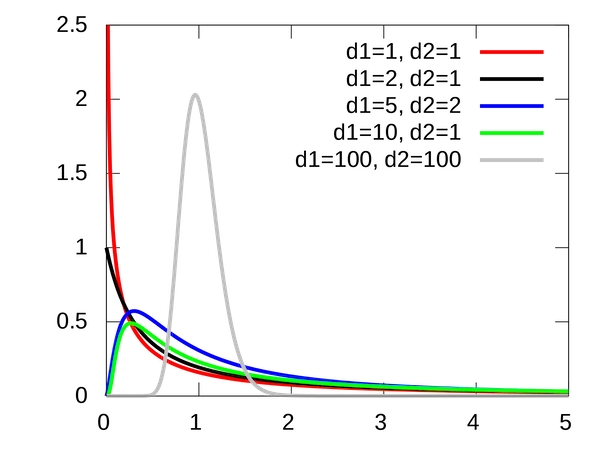

역시나 수식에 겁먹을 필요 없고, 분포의 형태를 결정하는 값이 무엇인지만 알면 됩니다. f-분포는 두 카이 제곱 분포의 비가 이루는 분포였습니다. 카이 제곱 분포는 자유도 k가 결정했습니다. 따라서 f 분포의 형태를 결정하는 것은 두 카이 제곱 분포의 자유도가 됩니다.

그럼 앞에서 구한 f-value가 왜 f 분포를 따르는지 살펴보겠습니다. 엄밀한 증명은 생략하고, 직관적으로 between variance는 전체 평균과 그룹 내 평균의 차의 제곱합, within variance는 그룹 내 각 자료와 그룹 내 평균의 제곱 합이고, 제곱 합들의 비율로 f-value를 계산하니까 f 분포를 따른다고 생각하면 됩니다.

## p-value 계산 및 통계적 의사 결정

다시 가설로 돌아오겠습니다. 우리가 알고 싶은건 3개 이상의 집단의 평균이 같은지 다른지였습니다. 이 때, between variance와 within variance를 계산할 수 있었습니다. 만일, between variance가 withint variance 보다 유의미하게 크다면, 적어도 한개의 집단의 평균은 나머지 집단과 다를 것입니다.이를 검정하기 위해 f-value를 계산한 다음, f 분포를 이용하여 p-value를 계산하여 유의 수준보다 낮은지 확인하면 됩니다.

In [10]:
from scipy.stats import f_oneway

In [11]:
groups = []

payment_methods = df["PaymentMethod"].unique()
for payment_method in payment_methods:
    groups.append(df[df["PaymentMethod"]==payment_method]["TotalCharges"])

In [12]:
f_statistic, p_value = f_oneway(*groups)
print("F-statistic:", f_statistic)
print("p-value:", p_value)
print("귀무 가설 기각 여부:", p_value<0.05)

F-statistic: 327.5236826310482
p-value: 4.608039633507195e-199
귀무 가설 기각 여부: True


one-way ANOVA 결과 p-value가 유의 수준보다 낮으므로 그룹 간 평균이 같다는 귀무가설을 기각합니다.

### ANOVA 후속 분석

one-way ANOVA 결과로 그룹 간 평균이 다르다는 것을 알게 되었습니다. 그렇다면 이제 각 그룹별로 평균을 비교해서 어느 집단과 어느 집단의 평균이 통계적으로 유의미하게 다른지 검정을 할 수 있습니다. 이를 후속 분석, post-hoc이라고 부릅니다. post-hoc에도 여러 기법을 사용할 수 있지만, 가장 대표적인 Tukey 기법을 사용해보겠습니다.

더 많은 사후 분석 종류에 대해서 궁금하신 분들은 아래 포스팅을 참고해주세요.  
ANOVA 사후 분석 종류 비교: https://m.blog.naver.com/statsol/221472155248

In [13]:
from scipy.stats import tukey_hsd

result = tukey_hsd(*groups)
result.pvalue

array([[1.00000000e+00, 1.31672451e-12, 1.31672451e-12, 1.31672451e-12],
       [1.31672451e-12, 1.00000000e+00, 1.31672451e-12, 1.31672451e-12],
       [1.31672451e-12, 1.31672451e-12, 1.00000000e+00, 9.99609220e-01],
       [1.31672451e-12, 1.31672451e-12, 9.99609220e-01, 1.00000000e+00]])

In [14]:
pvalue_table = pd.DataFrame(result.pvalue, columns=payment_methods, index=payment_methods)
pvalue_table

,Electronic check,Mailed check,Bank transfer,Credit card
Electronic check,1.000000e+00,1.316725e-12,1.316725e-12,1.316725e-12
Mailed check,1.316725e-12,1.000000e+00,1.316725e-12,1.316725e-12
Bank transfer,1.316725e-12,1.316725e-12,1.000000e+00,9.996092e-01
Credit card,1.316725e-12,1.316725e-12,9.996092e-01,1.000000e+00


<Axes: >

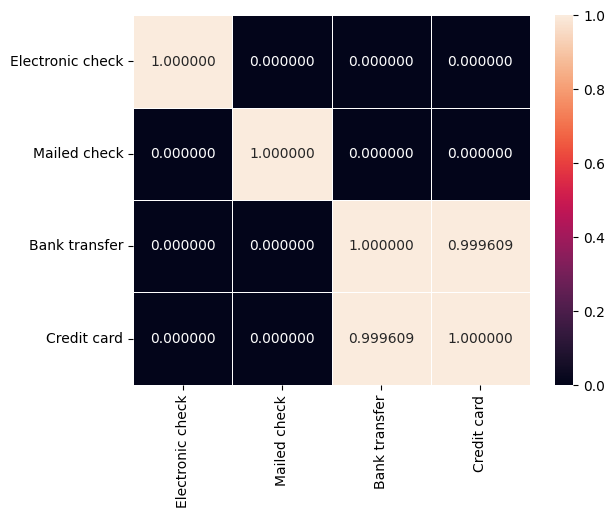

In [15]:
sns.heatmap(
    pvalue_table,
    annot=True,
    fmt=".6f",
    linewidth=0.5,
)

Tukey 기법을 사용하여 모든 그룹 조합에 대해서 평균이 같은지 여부를 검정해보았습니다. Bank Transfer와 Credit Card 그룹을 제외한 모든 조합들은 p-value가 유의 수준보다 낮아서 평균이 유의하게 달랐습니다.Bank Transfer와 Credit Card 그룹은 통계적으로 평균이 같다고 결론내릴 수 있습니다.

## 정리
지금까지 세 개 이상의 집단의 평균이 같은지 다른지를 검정하는 one-way ANOVA에 대해서 살펴보았습니다. 이외에도 ANOVA에는 다양한 종류가 있습니다. 주어진 데이터 셋에 적합한지 면밀히 검토하고 사용하면 좋겠습니다.

- 이원 분산 분석(Two-way ANOVA):
    - 독립 변수가 2개일 때 사용. 한 독립 변수의 변화가 종속 변수에 미치는 영향이 다른 독립 변수의 수준 변화에 따라 달라지는지 검정
    - 예시: Payment Method와 Contract라는 두 독립 변수에 따라서 각 그룹의 평균이 같은지 다른지, 그리고 Payment method와 Contract 두 독립변수가 교차 효과가 있는지 검정.
- 삼원 배치 분산 분석(Three-way ANOVA):
    - 독립 변수가 3개 이상일 때 사용. 해석이 어렵기 때문에 잘 사용 안함.
- 반복 측정 분산 분석(Repeated Measure ANOVA):
    - 같은 집단에 대해 여러번 측정을 한 데이터의 평균이 같은지 검정. paired t-test는 전과 후 2번 측정했을 때만 사용이 가능. 3번 이상은 repeated measure ANOVA를 사용

그 외 다양한 ANOVA 종류가 궁금하신 분들은 아래 링크를 참고해주세요
ANOVA 종류: https://www.qualtrics.com/kr/experience-management/research/anova/